# Imports and config

In [1]:
# Essentials
import numpy as np
import scipy
import pandas as pd
import datetime
import random
from scipy import stats

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.stats import kstest
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from scipy.stats import yeojohnson
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
import category_encoders as ce

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

# Date loading

In [2]:
def read_data():
    """
    Read in train and test data
    
    Args:
        None
        
    Returns:
        train (pandas dataframe) : train data
        test (pandas dataframe) : test data
    """
    
    # Read in the dataset as a dataframe
    train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
    test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
    
    return train, test

train, test = read_data()
train.shape, test.shape

((1460, 81), (1459, 80))

# EDA

Let's first preview the data.

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## SalePrice : the target

The saleprice is what we are trying to predict, so let's have a look at a plot of this.

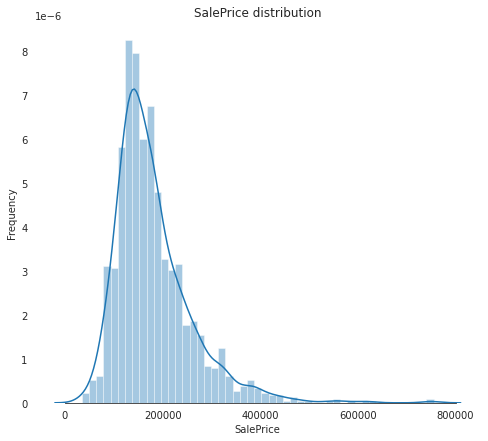

In [4]:
sns.set_style("white")
sns.set_color_codes(palette = 'deep')
figure, ax = plt.subplots(figsize = (8, 7))
sns.distplot(train["SalePrice"])
ax.set(ylabel = "Frequency")
ax.set(xlabel = "SalePrice")
ax.set(title = "SalePrice distribution")
sns.despine(trim = True, left = True)  # remove left border from plot
plt.show()

The distribution looks quite skewed, lets measure its skewness and kurtosis.

In [5]:
print("Skewness: {}".format(train["SalePrice"].skew()))
print("Kurtosis: {}".format(train["SalePrice"].kurtosis()))

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


A relatively skewed distribution large tails.

## Features

Let's plot the features against the target, to see get a good feel for them.

In [6]:
def find_numeric_features(features):
    """
    Find numeric features of a given feature set
    
    Args:
        features (pandas dataframe) : dataframe to inspect
        
    Returns:
        numeric (string[]) : numeric feature names 
    
    """
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    return numeric

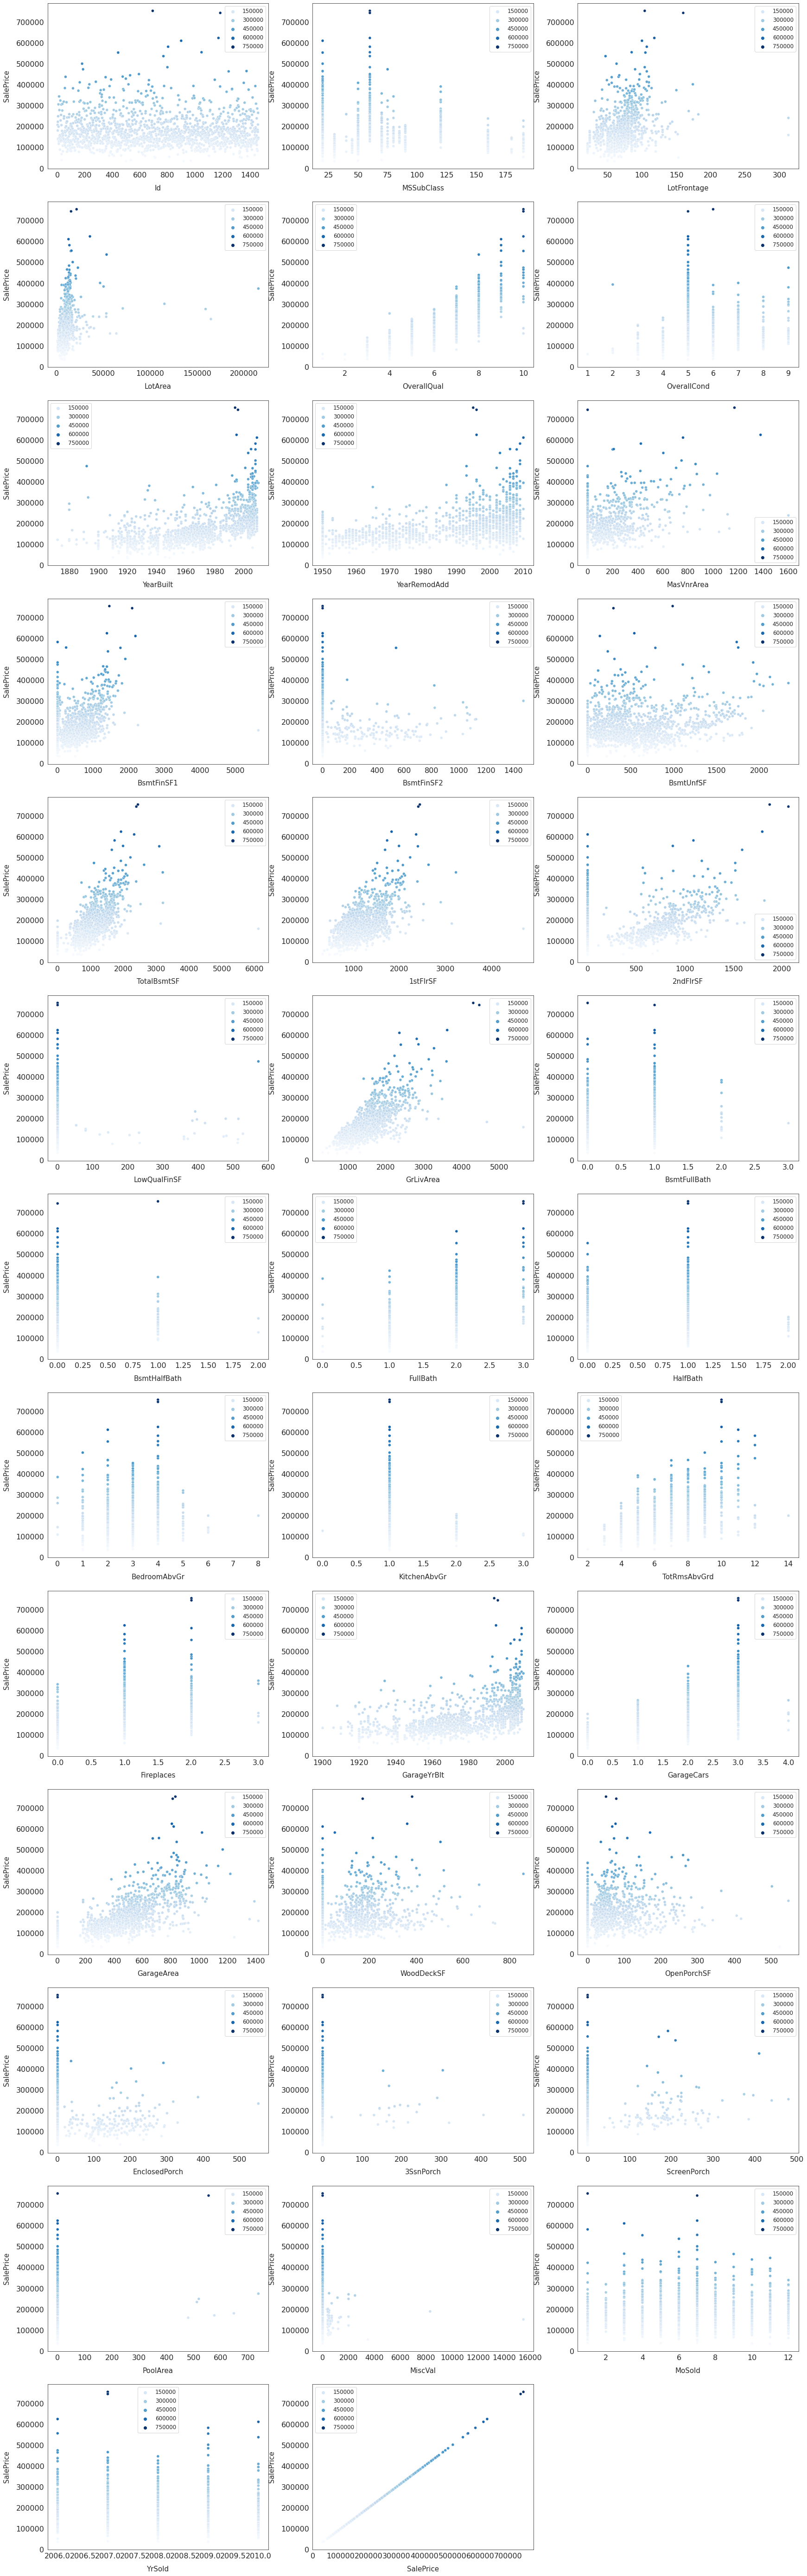

In [7]:
def plot_features_against_target(data):
    """
    Create scatter subplots of all features against target
    
    Args:
        data (pandas dataframe) : data whose features we want to plot
        
    Returns:
        None
    """

    # Finding numeric features
    numeric = find_numeric_features(data)         

    # define figure
    fig, axs = plt.subplots(ncols=3, figsize=(12, 120))

    # adjust spacing
    plt.subplots_adjust(right=2)
    plt.subplots_adjust(top=2)

    # set colour palette
    sns.color_palette("husl", 8)

    # for each feature
    for i, feature in enumerate(list(data[numeric]), 1):

        # plot data
        plt.subplot(len(list(numeric)), 3, i)
        sns.scatterplot(x = feature, y='SalePrice', hue='SalePrice', palette='Blues', data = data)

        # add axis labels
        plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
        plt.ylabel('SalePrice', size=15, labelpad=12.5)

        # change tick sizes
        plt.tick_params(axis='x', labelsize=16)
        plt.tick_params(axis='y', labelsize=16)

        # add legend
        plt.legend(loc='best', prop={'size': 12})

    plt.show()
    
plot_features_against_target(train)

We see that certain features like 'TotalBsmtSF' and 'GrLivArea' are strongly correlated with 'SalePrice'. Other features like 'BsmtFinSF2' have alsmost no correlation. There is also clearly a lot of outliers and corrupt data to remove.

Let's now plot a correlation heat map to see how features are correlated to each other and to SalePrice.

<AxesSubplot:>

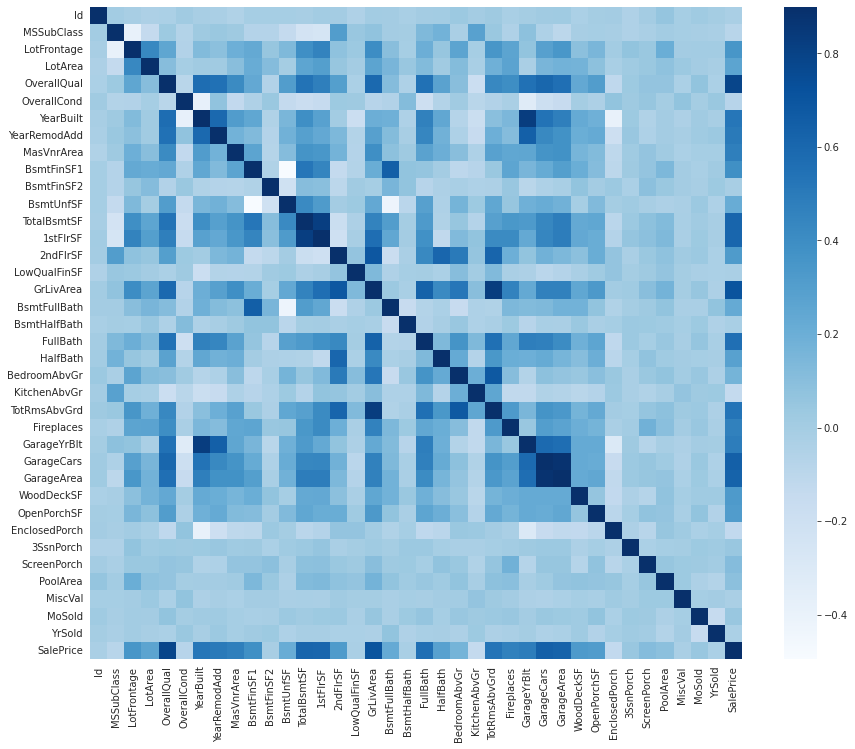

In [8]:
corr = train.corr()
plt.subplots(figsize = (15, 12))
sns.heatmap(corr, vmax = 0.9, cmap = 'Blues', square = True)

We see some strong correlations here, some more useful than others. For example, "GarageYrBlt" being strongly correlated with "YearBuilt" is not a surprising relationship.

Let's look at how some specfic features are correlated with the target.

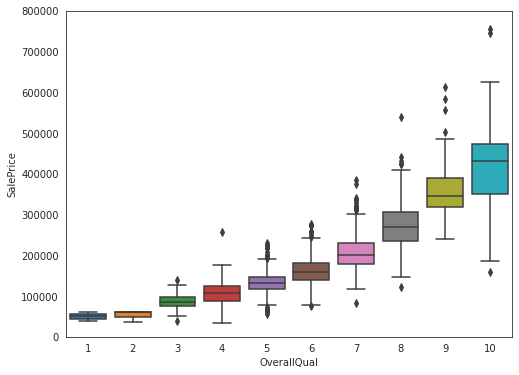

In [9]:
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=train['OverallQual'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

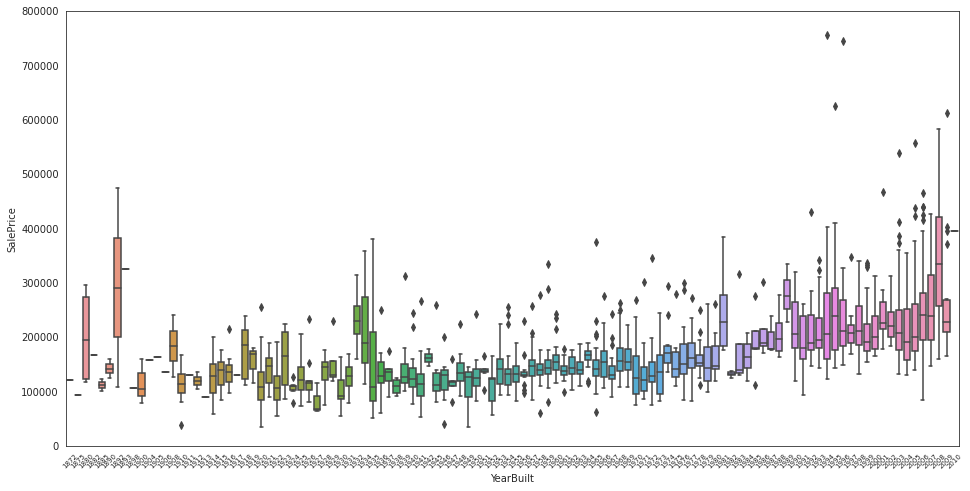

In [10]:
data = pd.concat([train['SalePrice'], train['YearBuilt']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=train['YearBuilt'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=45);
plt.tick_params(axis='x', labelsize=7)

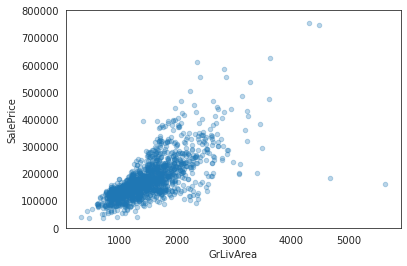

In [11]:
data = pd.concat([train['SalePrice'], train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', alpha=0.3, ylim=(0,800000));

# Data Cleaning

First we will remove the Ids from the train and test, as they are unique for each row and hence not useful for the model.

In [12]:
def drop_ID(X):
    """
    Drop the ID column since it is unique and so useless for ML
    
    Args:
        X (pandas dataframe) : dataframe whose ID col we want to trop
    
    Returns:
        X (pandas dataframe) : dataframe with ID's dropped
    """
    X.drop(['Id'], axis = 1, inplace = True)
    return X

train = drop_ID(train)
test = drop_ID(test)
train.shape, test.shape

((1460, 80), (1459, 79))

Now, lets look at the SalePrice distribution again.

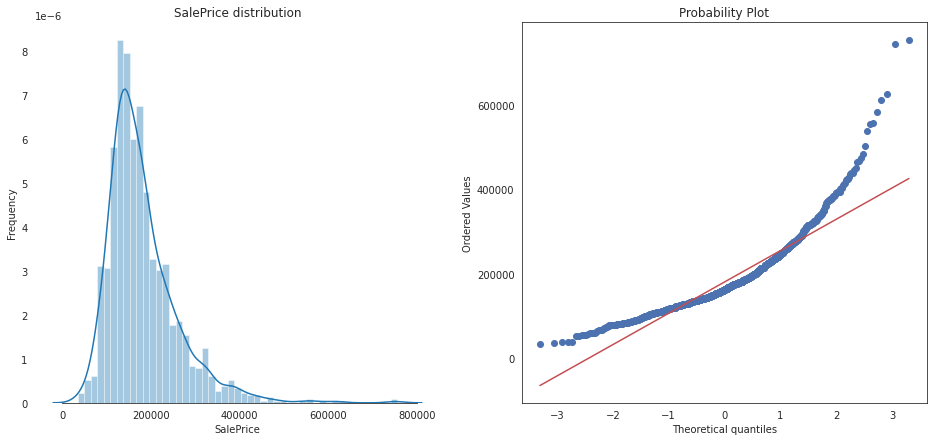

In [13]:
sns.set_style("white")
sns.set_color_codes(palette = 'deep')
figure = plt.subplots(figsize = (16, 7))

# histogram
plt.subplot(1, 2, 1)
sns.distplot(train["SalePrice"])
plt.ylabel("Frequency")
plt.xlabel(xlabel = "SalePrice")
plt.title("SalePrice distribution")
sns.despine(trim = True, left = True)  # remove left border from plot

# probability plot
plt.subplot(1, 2, 2)
stats.probplot(train["SalePrice"], dist="norm", plot=plt)

plt.show()

Notice that it is skewed to the right. This is bad as models do not work well with skewed data. In order to make it more normal, we want to apply some form of transformation. There are many that we can try such as log, sqrt, boxcox, reciprical, yeojohnson etc. I find that boxcox and yeojohnson give the same result so I'll use boxcox as its inverse is less fidely to work with.

In [14]:
def transform_target(X):
    """
    Transform target to make it normally distributed
    
    Params:
        X (pandas dataframe) : dataframe whose target we want to transform
        
    Returns:
        X (pandas dataframe) : transformed dataframe
    """
    #X["SalePrice"] = np.log1p(train["SalePrice"])
    X["SalePrice"], lamb = boxcox(X["SalePrice"])
    #X["SalePrice"] = 1/X["SalePrice"]
    #X["SalePrice"] = X["SalePrice"]**(0.5)
    #X["SalePrice"], lamb = yeojohnson(X["SalePrice"])
    
    return X, lamb

# apply transform
train, lamb = transform_target(train)

Now replot the distrubition alongside a fitted normal distribution to see how they compare.

mu = 7.84
sigma = 0.16


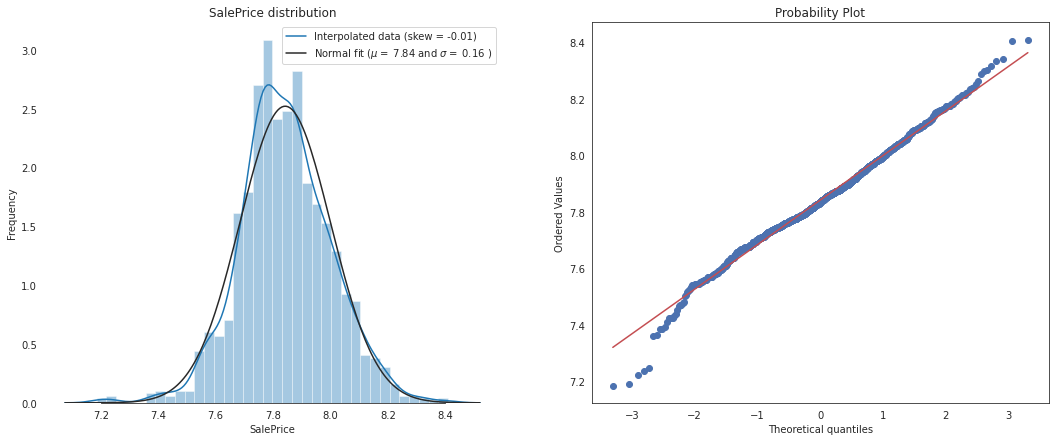

In [15]:
# set up figure
sns.set_style("white")
sns.set_color_codes(palette = 'deep')
figure, ax = plt.subplots(figsize = (18, 7))

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
s = skew(train["SalePrice"])
print('mu = {:.2f}'.format(mu))
print('sigma = {:.2f}'.format(sigma))

# histogram
plt.subplot(1, 2, 1)
sns.distplot(train["SalePrice"], fit = norm)
plt.legend(["Interpolated data (skew = {:.2f})".format(s),'Normal fit ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)])
plt.ylabel("Frequency")
plt.xlabel("SalePrice")
plt.title("SalePrice distribution")
sns.despine(trim = True, left = True)  # remove left border from plot

# probability plot
plt.subplot(1, 2, 2)
stats.probplot(train["SalePrice"], dist = 'norm', plot = plt)

plt.show()

The target is no longer skewed.

## Drop outliers

Using the plots we made before of specific features against the SalePrice, we will remove some of the outliers.

In [16]:
def drop_outliers(X):
    """
    Drop any identified outliers
    
    Args:
        X (pandas dataframe) : dataframe whose outliers we want to drop
        
    Returns:
        X (pandas dataframe) : dataframe with outliers dropped
    """
    X.drop(X[(X['OverallQual'] < 5) & (X['SalePrice'] > 200000)].index, inplace=True)
    X.drop(X[(X['GrLivArea'] > 4500) & (X['SalePrice'] < 300000)].index, inplace=True)
    X.reset_index(drop=True, inplace=True) # restores index after dropping
    return X

train = drop_outliers(train)

## Combine and splitting data

Here we define functions for combining and splitting the train and test data sets. These will be useful going forward.

In [17]:
def combine_train_and_test(train, test):
    """
    Combine train and test datasets as well as extracting target
    
    Args:
        train (pandas dataframe) : train dataset
        test (pandas dataframe) : test dataset
    
    Returns:
        y_train (pandas series) : target
        X (pandas dataframe) : combined data
    """
    y_train = train['SalePrice'].reset_index(drop=True)
    X_train = train.drop(['SalePrice'], axis=1) # drop the target
    X_test = test
    X = pd.concat([X_train, X_test]).reset_index(drop=True) # combine train and test
    
    return y_train, X

In [18]:
def split_train_and_test(X, target):
    """
    split the train and test sets from the combined data
    
    Args:
        X (pandas dataframe) : dataframe to split up
        target (pandas series) : target data
        
    Return:
        X_test (pandas dataframe) : test data
        X_train (pandas dataframe) : train data
    """
    X_train = X.iloc[:len(y_train), :]
    X_test = X.iloc[len(y_train):, :]
    return X_train, X_test

## Fill missing values

First, lets print the percentage of missing values from each column. Keep in mind that in some numerical columns we simply have a 0 instead of np.nan to represent a missing feature. We may also have the word "None".

In [19]:
def percent_missing(data):
    """
    Characterise missing data in a dataframe
    
    Args:
        df (pandas dataframe) : dataframe we want to inspect
    
    Returns:
        miss_df()
    """
    miss_df = ((data == 0).sum()).to_frame()
    miss_df = miss_df.rename(columns = {0: 'zeros'})
    miss_df.index.name = 'Feature'
    miss_df['np.nan'] = (data.isnull()).sum()
    miss_df['None'] = (data == "None").sum()
    miss_df['total'] = miss_df['zeros'] + miss_df['np.nan'] + miss_df['None']
    miss_df['Percent'] = 100*miss_df['total']/len(data)
    miss_df['Type'] = [data[i].dtype for i in miss_df.index ]
    return miss_df.sort_values(ascending = False, by = 'Percent')

_, all_data = combine_train_and_test(train, test)
miss_all = percent_missing(all_data)
miss_all.head()

,zeros,np.nan,None,total,Percent,Type
Feature,,,,,,
PoolQC,0,2908,0,2908,99.691464,object
PoolArea,2905,0,0,2905,99.588618,int64
3SsnPorch,2880,0,0,2880,98.731574,int64
LowQualFinSF,2877,0,0,2877,98.628728,int64
MiscVal,2814,0,0,2814,96.468975,int64


We see that there are a few columns with lots of missing data.  
Let's visualise this data.

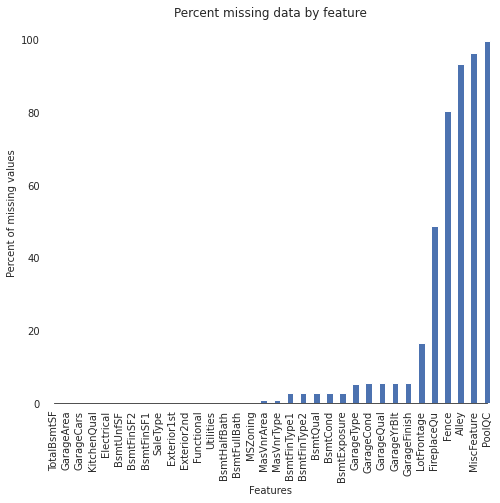

In [20]:
# set up figure with colour formatting
sns.set_style("white")
fig, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')

# determine columns with more than one missing value and sort in increasing orber
missing = round(all_data.isnull().mean()*100,2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color="b")

# tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)

Now we want to impute missing values for each of these features.  
We will implement the following strategy:
- Mean imputation for numerical features such as:   
    - 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea' (In df_train and df_test separately)
- Most frequent imputation for categorical features such as:  
    - 'MasVnrType', 'GarageFinish', 'GarageQual', 'GarageCond', 'MSZoning', 'Utilities', 'Functional', 'Exterior2nd', 'Exterior1st', 'SaleType', 'KitchenQual' (In df_train and df_test separately)
- Some features have a lot of zeroes but can be grouped together nicely. In such cases we will create new feature from a cominbation of the old ones and drop the original features:
    - New features:
        - 'Porch' = 'OpenPorchSF' + 'EnclosedPorch' + '3SsnPorch' + 'ScreenPorch'
        - 'Bath_total' = 'FullBath' + 0.5'HalfBath' + 'BsmtFullBath' + 0.5'BsmtHalfBath'
        - 'BsmtFinSF' = 'BsmtFinSF1' + 'BsmtFinSF2' - 'BsmtUnfSF'
        - 'FinSF' = '1stFlrSF' + '2ndFlrSF' - 'LowQualFinSF'
    - Drop original features:
        - 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
           'FullBath', 'HalfBath' , 'BsmtFullBath' ,'BsmtHalfBath',
           'BsmtFinSF1' , 'BsmtFinSF2' , 'BsmtUnfSF', 
           '1stFlrSF', '2ndFlrSF', 'LowQualFinSF'
- Features with large percentages of zero, nan or none should just be dropped from the dataset:
    - 'PoolQC', 'PoolArea', 'MiscFeature', 'MiscVal', 'Alley', 'Fence', 'WoodDeckSF', 'FireplaceQu', 'Fireplaces', 'MasVnrType', 'MasVnrArea'
- There are a few features with nan, for example to do with the basement, but this likely means there just isn't a basement, so we will replace these with none:
    - 'BsmtQual','BsmtCond','BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQu', 'GarageCond'
- Other zeros have reasons to be zero
- np.nan values to be zeros: 
    - GarageYrBlt should be zeros (but this feature sould be converted to categorical later)
    - GarageArea, GarageCars
- np.nan values in 'MasVnrArea' should be zeros
- 'LotFrontage' to be imputed using a regression model (In df_train and df_test separately)

In [21]:
def handle_missing(df_train, df_test):

    # list categorical and numerical features to impute
    cat_feat = ['GarageFinish', 'GarageQual', 'GarageCond', 'MSZoning','Utilities', 'Functional', 'Exterior2nd', 'Exterior1st', 
                'SaleType', 'KitchenQual']
    num_feat = ['BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2','BsmtFinSF1']

    # impute train data
    cat_imputer_train = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
    df_train.loc[:,cat_feat] = cat_imputer_train.fit_transform(df_train.loc[:, cat_feat])
    num_imputer_train = SimpleImputer(missing_values= np.nan, strategy = 'mean')
    df_train.loc[:, num_feat] = num_imputer_train.fit_transform(df_train.loc[:, num_feat])

    # impute test data
    cat_imputer_test = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
    df_test.loc[:,cat_feat] = cat_imputer_test.fit_transform(df_test.loc[:, cat_feat])
    num_imputer_test = SimpleImputer(missing_values= np.nan, strategy = 'mean')
    df_test.loc[:, num_feat] = num_imputer_test.fit_transform(df_test.loc[:, num_feat])

    # create new features
    df_train['Bath_total'] = df_train['FullBath'] + 0.5*df_train['HalfBath'] + df_train['BsmtFullBath'] + 0.5*df_train['BsmtHalfBath']
    df_test['Bath_total'] = df_test['FullBath'] + 0.5*df_test['HalfBath'] + df_test['BsmtFullBath'] + 0.5*df_test['BsmtHalfBath']

    df_train['BsmtFinSF'] = df_train['BsmtFinSF1'] + df_train['BsmtFinSF2'] - df_train['BsmtUnfSF']
    df_test['BsmtFinSF'] = df_test['BsmtFinSF1'] + df_test['BsmtFinSF2'] - df_test['BsmtUnfSF']

    df_train['Porch'] = df_train['OpenPorchSF'] + df_train['EnclosedPorch'] + df_train['3SsnPorch'] + df_train['ScreenPorch']
    df_test['Porch'] = df_test['OpenPorchSF'] + df_test['EnclosedPorch'] + df_test['3SsnPorch'] + df_test['ScreenPorch']

    df_train['FinSF'] = df_train['1stFlrSF'] + df_train['2ndFlrSF'] - df_train['LowQualFinSF']
    df_test['FinSF'] = df_test['1stFlrSF'] + df_test['2ndFlrSF'] - df_test['LowQualFinSF']

    # drop useless columns
    cols_to_drop = ['PoolQC', 'PoolArea', 'MiscFeature', 'MiscVal', 'Alley', 'Fence', 'WoodDeckSF',
                'FireplaceQu', 'Fireplaces', 'MasVnrType', 'MasVnrArea',
                'FullBath', 'HalfBath' , 'BsmtFullBath' ,'BsmtHalfBath',
                'BsmtFinSF1' , 'BsmtFinSF2' , 'BsmtUnfSF', 
                'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
                '1stFlrSF', '2ndFlrSF', 'LowQualFinSF']
    df_train = df_train.drop(cols_to_drop, axis = 1)
    df_test = df_test.drop(cols_to_drop, axis = 1)

    # convert some nans to none
    cols_to_None = ['BsmtQual','BsmtCond','BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 
                    'GarageFinish', 'GarageQual', 'GarageCond']
    df_train[cols_to_None] = df_train.loc[:,cols_to_None].replace(to_replace = np.nan, value = "None", inplace = False)
    df_test[cols_to_None] = df_test.loc[:,cols_to_None].replace(to_replace = np.nan, value = "None", inplace = False)

    # convert some nans to zero
    cols_to_zero = ['GarageYrBlt', 'GarageArea', 'GarageCars']
    df_train[cols_to_zero] = df_train[cols_to_zero].fillna(0)
    df_test[cols_to_zero] = df_test[cols_to_zero].fillna(0)
    
    # impute lot frontage with a regression model on train data
    df_train_totrain = df_train[df_train['LotFrontage'].isnull() == False]
    df_train_totest = df_train[df_train['LotFrontage'].isnull() == True]
    reg = XGBRegressor(n_estimators = 5000, learning_rate = 0.01)
    reg.fit(df_train_totrain.select_dtypes(exclude = 'object').drop(['LotFrontage', 'SalePrice'], axis = 1), 
            df_train_totrain['LotFrontage'], verbose = False)
    df_train_totest['LotFrontage'] = reg.predict(df_train_totest.select_dtypes(exclude = 'object').drop(['LotFrontage', 'SalePrice'], axis = 1))
    df_train = pd.concat([df_train_totrain, df_train_totest])
    
    # impute lot frontage with a regression model on test data
    df_test_totrain = df_test[df_test['LotFrontage'].isnull() == False]
    df_test_totest = df_test[df_test['LotFrontage'].isnull() == True]
    reg_test = XGBRegressor(n_estimators = 5000, learning_rate = 0.01)
    reg_test.fit(df_test_totrain.select_dtypes(exclude = 'object').drop(['LotFrontage'], axis = 1), df_test_totrain['LotFrontage'], 
            verbose = False)
    df_test_totest['LotFrontage'] = reg_test.predict(df_test_totest.select_dtypes(exclude = 'object').drop(['LotFrontage'], axis = 1))
    df_test = pd.concat([df_test_totrain, df_test_totest])
    
    return df_train, df_test 

train, test = handle_missing(train, test)

Now lets check that we have indeeded removed all missing data.

In [22]:
miss_train = percent_missing(train)
miss_train.head()

,zeros,np.nan,None,total,Percent,Type
Feature,,,,,,
Porch,458,0,0,458,31.412894,int64
GarageYrBlt,81,0,0,81,5.555556,float64
GarageArea,81,0,0,81,5.555556,float64
GarageType,0,0,81,81,5.555556,object
GarageCars,81,0,0,81,5.555556,float64


In [23]:
miss_test = percent_missing(test)
miss_test.head()

,zeros,np.nan,None,total,Percent,Type
Feature,,,,,,
Porch,415,0,0,415,28.444140,int64
GarageYrBlt,78,0,0,78,5.346127,float64
GarageArea,76,0,0,76,5.209047,float64
GarageType,0,0,76,76,5.209047,object
GarageCars,76,0,0,76,5.209047,float64


As desired, there are no missing values anymore.

## Categorical Features

Firstly, it might be the case that a categorical feature in our data has unique categories that only appear in either the training or the test dataset. So we should compare features with unique values and handle accordingly.

The first thing to look at is the date features. Since there are a lot of unique dates in both, we should group by every five years.

In [24]:
def group_dates(date_cols, train, test):
    """
    Group date features by 5 years
    
    Args:
        date_cols (string[]) : date columns we want to group 
        train (pandas dataframe) : train data
        test (pandas dataframe) : test data
        
    Returns:
        train (pandas dataframe) : train data with group dates
        test (pandas dataframe) : test data with grouped dates
    """
    train[date_cols] = round(train[date_cols]/5)*5
    test[date_cols] = round(train[date_cols]/5)*5
    return train, test

date_cols = ["YearBuilt", "YearRemodAdd", "GarageYrBlt"]
train, test = group_dates(date_cols, train, test)

Let's write some functions to inspect the category columns.

In [25]:
def compare_col(col, df_train, df_test):
    """
    Compare single column of train and test data
    
    Args:
        col (string) : category column we want to investigate
        df_train (pandas dataframe) : train data
        df_test (pandas dataframe) : test data
        
    Returns:
        None
    """
    print(f"feature is: {col}")
        
    # get number of unique categorites in that feature
    train_unique_count = len(df_train[col].unique())
    test_unique_count = len(df_test[col].unique())
    print(f"# of train unique values is: {train_unique_count}")
    print(f"# of test unique values is: {test_unique_count}")

    # merge the unique values
    all_values = set(df_train[col]).union(set(df_test[col]))

    # create a new dataframe with uniqe categories, their counts and percentages of that column
    D = pd.DataFrame({'Unique': list(all_values)})
    D['train_count'] = [len(df_train[df_train[col] == cat]) for cat in all_values]
    D['train_percent'] = (D['train_count']/ len(df_train)) * 100
    D['test_count'] = [len(df_test[df_test[col] == cat]) for cat in all_values]
    D['test_percent'] = (D['test_count']/ len(df_test)) * 100

    # sort according to train count
    print(D.sort_values('train_count', ascending = False))
    print('--------------------')
    

def compare_cols(cols, df_train, df_test):
    """
    Compare categorical columns of train and test data
    
    Args:
        cols (string[]) : category columns we want to investigate
        df_train (pandas dataframe) : train data
        df_test (pandas dataframe) : test data
        
    Returns:
        None
    """
    
    # loop through all features
    counter = 1
    for col in cols:
        compare_col(col, df_train, df_test)
        print(f"Total number of navigated features is: {counter}")
        counter += 1
        print('--------------------') 

Now we can look at the date columns to check that there are no categories that uniquly appear in train or test.

In [26]:
compare_cols(date_cols, train, test)

feature is: YearBuilt
# of train unique values is: 29
# of test unique values is: 30
    Unique  train_count  train_percent  test_count  test_percent
20  2005.0          278      19.067215         278     19.054147
18  2000.0          117       8.024691         117      8.019191
11  1970.0          105       7.201646         105      7.196710
9   1960.0          100       6.858711         100      6.854010
12  1975.0           94       6.447188          94      6.442769
10  1965.0           89       6.104252          89      6.100069
8   1955.0           86       5.898491          86      5.894448
16  1995.0           83       5.692730          83      5.688828
7   1950.0           57       3.909465          57      3.906785
0   1920.0           54       3.703704          54      3.701165
5   1940.0           47       3.223594          47      3.221385
13  1980.0           46       3.155007          46      3.152844
15  1990.0           44       3.017833          44      3.015764
2   1

There are a number of features that are listed as numerical, when in actualy factor they would be better as categorical features so we will convert them to strings.

In [27]:
def convert_num_to_cat(cols, X):
    """
    Convert numerical features to categorical
    
    Args:
        X (pandas dataframe) : dataframe to transform
        
    Returns:
        X (pandas dataframe) : transformed dataframe
    """
    for col in cols:
        X[col] = X[col].astype(str)
    
    return X

num_to_cat_cols = ['MSSubClass', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'MoSold']
train = convert_num_to_cat(num_to_cat_cols, train)
test = convert_num_to_cat(num_to_cat_cols, test)

Now let's compare all categorical features.

In [28]:
_, all_data = combine_train_and_test(train, test)
cat_cols = all_data.select_dtypes(include=['object']).columns
compare_cols(cat_cols, train, test)

feature is: MSSubClass
# of train unique values is: 15
# of test unique values is: 16
   Unique  train_count  train_percent  test_count  test_percent
11     20          536      36.762689         543     37.217272
7      60          297      20.370370         276     18.917066
6      50          144       9.876543         143      9.801234
14    120           87       5.967078          95      6.511309
15     30           69       4.732510          70      4.797807
0     160           63       4.320988          65      4.455106
8      70           60       4.115226          68      4.660727
13     80           58       3.978052          60      4.112406
4      90           52       3.566529          57      3.906785
12    190           30       2.057613          31      2.124743
3      85           20       1.371742          28      1.919123
9      75           16       1.097394           7      0.479781
5      45           12       0.823045           6      0.411241
2     180         

Firstly, lets combine 'Condition1' and 'Condition2' into a single feature 'Condition', then put all values with count less than 4 into a new category 'other'.

In [29]:
def handle_condition_feature(train, test):
    """
    Deal with the condition feature
    
    Args:
        train (pandas dataframe) : train data
        test (pandas dataframe) : test data
    
    Returns:
        train (pandas dataframe) : train data with condition feature handled
        test (pandas dataframe) : test data with condition feature handled
    """
    # combine categories
    train['Condition'] = train['Condition1'] + '_' + train['Condition2']
    test['Condition'] = test['Condition1'] + '_' + test['Condition2']

    # drop original from dataset
    train = train.drop(['Condition1', 'Condition2'], axis =1)
    test = test.drop(['Condition1', 'Condition2'], axis =1)

    # replace all categories with count less than 5 with other
    to_replace_train = [i for i in train['Condition'].unique() if train['Condition'].value_counts()[i] < 5]
    to_replace_test = [i for i in test['Condition'].unique() if test['Condition'].value_counts()[i] < 5]
    train['Condition'] = train['Condition'].replace(to_replace= to_replace_train, value = 'Other', inplace=False)
    test['Condition'] = test['Condition'].replace(to_replace = to_replace_test, value = 'Other', inplace = False)
    
    return train, test

train, test = handle_condition_feature(train, test)

Let's inspect the condition column now.

In [30]:
compare_col("Condition", train, test)

feature is: Condition
# of train unique values is: 8
# of test unique values is: 8
        Unique  train_count  train_percent  test_count  test_percent
0    Norm_Norm         1260      86.419753        1251     85.743660
6   Feedr_Norm           75       5.144033          79      5.414668
3  Artery_Norm           45       3.086420          44      3.015764
1    RRAn_Norm           22       1.508916          19      1.302262
4        Other           20       1.371742          22      1.507882
2    PosN_Norm           17       1.165981          18      1.233722
5    RRAe_Norm           11       0.754458          17      1.165182
7    PosA_Norm            8       0.548697           9      0.616861
--------------------


Now lets drop any features where one category makes up 90% or more of the feature.

In [31]:
def drop_high_unique_cols(train, test):
    """
    Drop any feature where a category makes up 90% or more of the feature
    
    Args:
        train (pandas dataframe) : train data
        test (pandas dataframe) : test data
    
    Returns:
        train (pandas dataframe) : train data with high unique cols removed
        test (pandas dataframe) : test data with high unique cols removed
    """
    cols_to_drop = []
    for col in train.select_dtypes(include = "object").columns:
        max_unique_percent_cat = max([len(train[train[col] == unique_cat]) for unique_cat in train[col].unique()])
        percent = round(max_unique_percent_cat/len(train) * 100)
        if percent >= 90: cols_to_drop.append(col)
    train = train.drop(cols_to_drop, axis = 1)
    test = test.drop(cols_to_drop, axis = 1)
    
    return train, test

train, test = drop_high_unique_cols(train, test)

In [32]:
_, all_data = combine_train_and_test(train, test)
cat_cols = all_data.select_dtypes(include=['object']).columns
compare_cols(cat_cols, train, test)

feature is: MSSubClass
# of train unique values is: 15
# of test unique values is: 16
   Unique  train_count  train_percent  test_count  test_percent
11     20          536      36.762689         543     37.217272
7      60          297      20.370370         276     18.917066
6      50          144       9.876543         143      9.801234
14    120           87       5.967078          95      6.511309
15     30           69       4.732510          70      4.797807
0     160           63       4.320988          65      4.455106
8      70           60       4.115226          68      4.660727
13     80           58       3.978052          60      4.112406
4      90           52       3.566529          57      3.906785
12    190           30       2.057613          31      2.124743
3      85           20       1.371742          28      1.919123
9      75           16       1.097394           7      0.479781
5      45           12       0.823045           6      0.411241
2     180         

Some features maybe better to be ordinal encoded:
- ExterQual:- 
                Po : 1, Fa : 2, TA : 3, Gd : 4, Ex : 5
- ExterCond:- 
                Po : 1, Fa : 2, TA : 3, Gd : 4, Ex : 5
- BsmtQual:- 
                None : 0, Po : 1, Fa : 2, TA : 3, Gd : 4, Ex : 5
- BsmtExposure:- 
                None : 0, No : 1, Mn : 2, Av : 3, Gd : 4
- BsmtFinType1:- 
                None : 0, Unf : 1, LwQ : 2, Rec : 3, BLQ : 4, ALQ : 5, GLQ : 6
- BsmtFinType2:-
                None : 0, Unf : 1, LwQ : 2, Rec : 3, BLQ : 4, ALQ : 5, GLQ : 6
- HeatingQC:- 
                Po : 1, Fa : 2, TA : 3, Gd : 4, Ex : 5
- KitchenQual:- 
                Po : 1, Fa : 2, TA : 3, Gd : 4, Ex : 5
- GarageFinish:- 
                None : 0, Unf : 1, RFn : 2, Fin : 3

In [33]:
def ordinal_encode(train, test):
    """
    Apply ordinal encoding
    
    Args:
        train (pandas dataframe) : train data
        test (pandas dataframe) : test data
    
    Returns:
        train (pandas dataframe) : train data after ordinal encoding
        test (pandas dataframe) : test data after ordinal encoding
    """

    cols_OE = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 
               'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'GarageFinish']
    dic = {'None':0, 
           'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 
           'No': 1, 'Mn': 2, 'Av': 3, 
           'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6, 
           'RFn': 2, 'Fin': 3}

    train[cols_OE] = train[cols_OE].replace(dic, inplace = False)
    test[cols_OE] = test[cols_OE].replace(dic, inplace = False)
    
    return train, test

train, test = ordinal_encode(train, test)

We will then categorical encode all remaining category features.

In [34]:
def cat_encode(train, test):
    """
    Apply categorical encoding
    
     Args:
        train (pandas dataframe) : train data
        test (pandas dataframe) : test data
    
    Returns:
        train (pandas dataframe) : train data after categorical encoding
        test (pandas dataframe) : test data after categorical encoding
    """

    # get category columns 
    cols_CE = train.select_dtypes(include= 'object').columns
    
    # apply category encoding
    cbe = ce.cat_boost.CatBoostEncoder(a = 1)
    cbe.fit(train[cols_CE], train['SalePrice'])
    train[cols_CE] = cbe.transform(train[cols_CE])
    test[cols_CE] = cbe.transform(test[cols_CE])
    
    return train, test

train, test = cat_encode(train, test)

We have done quite a few transformations in this section so we will bundle them all into one function to use conviniently in our pipeline later on.

In [35]:
def cat_features(train, test):
    """
    Apply all processes to handle categorical features
    
     Args:
        train (pandas dataframe) : train data
        test (pandas dataframe) : test data
    
    Returns:
        train (pandas dataframe) : train data after all categorical features handled
        test (pandas dataframe) : test data after all categorical features handled
    """
    # group date
    train, test = group_dates(date_cols, train, test)

    # convert numerical features to categorical ones where applicable
    train = convert_num_to_cat(num_to_cat_cols, train)
    test = convert_num_to_cat(num_to_cat_cols, test)

    # handle the specific condition feature
    train, test = handle_condition_feature(train, test)

    # drop features with high uniqueness
    train, test = drop_high_unique_cols(train, test)

    # apply oridinal encoding on specific features
    train, test = ordinal_encode(train, test)

    # apply categorical encoding on specific features
    train, test = cat_encode(train, test)
    
    return train, test

In [36]:
y_train, X = combine_train_and_test(train, test)
X.shape

(2917, 44)

## Fix skewed features

Models struggle to deal with non normally distributed features, so we want to transform these in some way.  
Lets plot the numeric features.

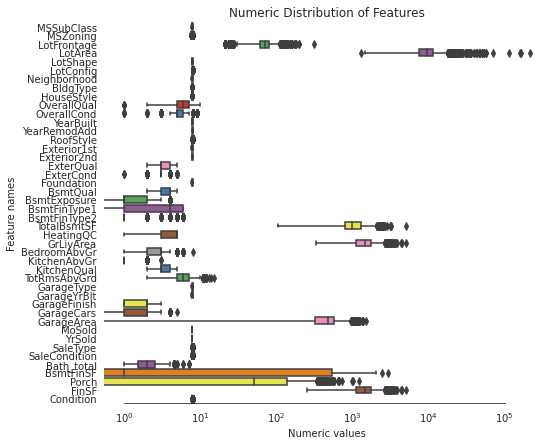

In [37]:
def plot_numeric_feature_distributions(features):
    """
    Create boxplot distribution of numeric features
    
    Args:
        features (pandas dataframe) : dataframe to inspect
        
    Returns:
        None
    """

    # set up figure
    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(8, 7))
    ax.set_xscale("log")

    # find numeric features and plot
    numeric = find_numeric_features(features)
    ax = sns.boxplot(data = features[numeric] , orient="h", palette="Set1")

    # edit figure
    ax.xaxis.grid(False)
    ax.set(ylabel="Feature names")
    ax.set(xlabel="Numeric values")
    ax.set(title="Numeric Distribution of Features")
    sns.despine(trim=True, left=True)
    
plot_numeric_feature_distributions(X)

Let's set a cutoff of skew = 0.5 and find features with a high skewness.

In [38]:
def find_skewed_features(features, cutoff):
    """
    Determine all features which are skewed above some threshold
    
    Args:
        features (pandas dataframe) : dataframe to inspect
        cutoff (int) : minimum skew
        
    Returns
        skew_features (pandas series) : skewness of each numeric feature
        high_skew_index (pandas index) : names of high skew features
    
    """
    
    numeric = find_numeric_features(features) # get numeric features
    skew_features = features[numeric].apply(lambda x : skew(x)).sort_values(ascending = False) # find skewed features and sort
    high_skew = skew_features[skew_features > skew_cutoff] # filter by skew cutoff
    high_skew_index = high_skew.index
    return skew_features, high_skew_index

In [39]:
skew_cutoff = 0.5
skew_features, high_skew_index = find_skewed_features(X, skew_cutoff)

# print results
print("There are {} numerical features with a skew > {}:".format(skew_features.shape[0], skew_cutoff))
skew_features.head(10)

There are 44 numerical features with a skew > 0.5:


LotArea          13.109495
KitchenAbvGr      4.300550
LotConfig         3.366827
BsmtFinType2      3.150951
SaleType          2.550032
Porch             2.244500
SaleCondition     1.806377
RoofStyle         1.320918
ExterCond         1.315069
BsmtExposure      1.119066
dtype: float64

We can use boxcox1 function to compute the Box-Cox transformation.

In [40]:
def fix_skewed_features(X):
    """
    Find then fix skewed features
    
    Args:
        X (pandas dataframe) : dataframe whose skewed features we want to fix
        
    Returns
        X (pandas dataframe) : dataframe with skewed features fixed
    """
    
    # find all skewed features
    kew_cutoff = 0.5
    skew_features, high_skew_index = find_skewed_features(X, skew_cutoff)
    
    # transform features
    for i in high_skew_index:
        X[i] = boxcox1p(X[i], boxcox_normmax(X[i] + 1))
        
    return X

X = fix_skewed_features(X)

Let's plot the numeric features again and see if we have corrected the skewness.

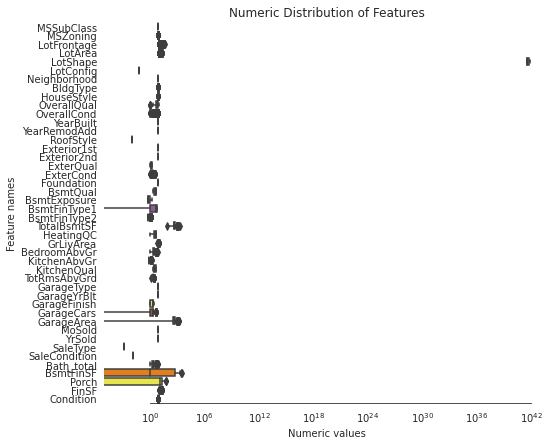

In [41]:
plot_numeric_feature_distributions(X)

The features are much less skewed now.

# Feature Engineering

## Creating features

ML models have trouble with complex features, so we will create some simpler ones using intution.

In [42]:
def create_new_features(X):
    """
    Create new features for the data
    
    Args:
        X (pandas dataframe) : dataframe which we want to determine new features for
    
    Returns:
        X (pandas dataframe) : dataframe with new features    
    """

    # features that determine whether the property possesses something
    #X['BsmtFinType1_Unf'] = (X['BsmtFinType1'] == 'Unf') * 1
    X['HasGarage'] = (X['GarageArea'] == 0) * 1
    X['HasBsmt'] = (X['TotalBsmtSF'] == 0) * 1

    # add some features together
    X['Total_Home_Quality'] = X['OverallQual'] + X['OverallCond']

    # other interesting things
    X['YearsSinceRemodel'] = X['YrSold'].astype(int) - X['YearRemodAdd'].astype(int)
    X['YrBltAndRemod'] = X['YearBuilt'] + X['YearRemodAdd']
    
    return X

X = create_new_features(X)

## Feature transformations

ML models struggle to tell if log(feature) or (feature)^2 is a good predictor of the target, so we will manually add these.

In [43]:
def log_transform(features, log_features):
    """
    Use log transform on certain features and store them in the dataframe
    
    Args:
        features (pandas dataframe) : dataframe where new features will be stored
        log_features (string[]) : names of features to log transform
        
    Returns:
        features (pandas dataframe) : transformed dataframe
    """
    for log_feature in log_features:
        features[log_feature + '_log'] = np.log(1.01 + features[log_feature])
    return features

# get all features to log transform
log_features = ['LotFrontage','LotArea',
                'TotalBsmtSF','GrLivArea',
                'BedroomAbvGr','KitchenAbvGr',
                'TotRmsAbvGrd','GarageCars','GarageArea','YearRemodAdd']

# apply log transform
X = log_transform(X, log_features)

In [44]:
def square_transform(features, squ_features):
    """
    Use square transform on certain features and store them in the dataframe
    
    Args:
        features (pandas dataframe) : dataframe where new features will be stored
        squ_features (string[]) : names of features to square transform
        
    Returns:
        features (pandas dataframe) : transformed dataframe
    """
    for squ_feature in squ_features:
        features[squ_feature + "_squ"] = features[squ_feature] * features[squ_feature]
    return features

# get all features to square transform
squared_features = ['YearRemodAdd', 'LotFrontage_log', 
                    'TotalBsmtSF_log', 'GrLivArea_log',
                    'GarageCars_log', 'GarageArea_log']

# apply square transform
X = square_transform(X, squared_features)

# Data pipeline

We know want to combine all of the above steps into a single pipeline function.

In [45]:
def data_pipeline():
    """
    Data pipeline to read, clean and engineer features
    
    Args:
        None
        
    Returns:
        X_train (pandas dataframe) : train data
        X_test (pandas dataframe) : test data
        y_train (pandas series) : target
    """
    # read in data
    train, test = read_data()

    # drop id column
    train = drop_ID(train)
    test = drop_ID(test)
    
    # transform the target to normalise
    train, lamb = transform_target(train)

    # drop outliers
    train = drop_outliers(train)

    # fill all missing values
    train, test = handle_missing(train, test)
    
    # handle categorical features
    train, test = cat_features(train, test)
    
    # extract target and combine train and test
    y_train, X = combine_train_and_test(train, test)

    # normalise skewed features
    X = fix_skewed_features(X)

    # create new features
    X = create_new_features(X)

    # log transform 
    log_features = ['LotFrontage','LotArea',
                'TotalBsmtSF','GrLivArea',
                'BedroomAbvGr','KitchenAbvGr',
                'TotRmsAbvGrd','GarageCars','GarageArea','YearRemodAdd']
    X = log_transform(X, log_features)

    # square transform
    squared_features = ['YearRemodAdd', 'LotFrontage_log', 
                    'TotalBsmtSF_log', 'GrLivArea_log',
                    'GarageCars_log', 'GarageArea_log']
    X = square_transform(X, squared_features)

    # decouple the train and test data
    X_train, X_test = split_train_and_test(X, y_train)

    return X_train, X_test, y_train, lamb

X_train, X_test, y_train, lamb = data_pipeline()
X_train.shape, X_test.shape, y_train.shape

((1458, 65), (1459, 65), (1458,))

In [46]:
def data_pipeline():
    """
    Data pipeline to read, clean and engineer features
    
    Args:
        None
        
    Returns:
        X_train (pandas dataframe) : train data
        X_test (pandas dataframe) : test data
        y_train (pandas series) : target
    """
    # read in data
    train, test = read_data()

    # drop id column
    train = drop_ID(train)
    test = drop_ID(test)
    
    # transform the target to normalise
    train, lamb = transform_target(train)

    # drop outliers
    train = drop_outliers(train)

    # fill all missing values
    train, test = handle_missing(train, test)
    
    # handle categorical features
    train, test = cat_features(train, test)
    
    # extract target and combine train and test
    y_train, X = combine_train_and_test(train, test)
    
    # decouple the train and test data
    train, test = split_train_and_test(X, y_train)

    return train, test, y_train

X_train, X_test, y_train = data_pipeline()
X_train.shape, X_test.shape, y_train.shape

((1458, 44), (1459, 44), (1458,))

In [47]:
X_train.isnull().values.any(), X_test.isnull().values.any(), y_train.isnull().values.any()

(False, False, False)

# Building a model

## Key features of training a model:
- **Cross Validation** Using 12-fold cross-validation
- **Models:** On each run of cross-validation I fit 7 models (ridge, svr, gradient boosting, random forest, xgboost, lightgbm regressors)
- **Stacking:** In addition, I trained a meta StackingCVRegressor optimized using xgboost
- **Blending:** All models trained will overfit the training data to varying degrees. Therefore, to make final predictions, I blended their predictions together to get more robust predictions.

## Setup cross validation and define error metrics

We will use a 12 fold validation.

In [48]:
kf = KFold(n_splits = 12, random_state = 42, shuffle = True)

The error metric we use is the root mean squared log error (rmsle).

In [49]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(np.log(y), np.log(y_pred)))

def cv_rmse(model, X, y):
    score = cross_val_score(
        model, X, y, cv=kf, scoring="neg_mean_squared_error",
    )
    score = np.sqrt(-score)
    score_mean = score.mean()
    score_std = score.std()
    return score_mean, score_std

## Setup models

Let's setup the models now. To begin with we will keep all hyperparameters to their default values. These can be tweaked later.

In [50]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=4,
                       learning_rate=0.01, 
                       n_estimators=5000,
                       max_bin=200, 
                       bagging_fraction=0.75,
                       bagging_freq=5, 
                       bagging_seed=7,
                       feature_fraction=0.2,
                       feature_fraction_seed=7,
                       verbose=-1)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=3460,
                       max_depth=3, 
                       min_child_weight=0,
                       gamma=0, 
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror', 
                       nthread=-1,
                       scale_pos_weight=1, 
                       seed=27,
                       reg_alpha=0.00006)

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

# Ridge Regressor
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kf))

# Lasso
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kf))

# Elasticnet
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004,0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kf, l1_ratio=e_l1ratio))   

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=3000, 
                                learning_rate=0.05, 
                                max_depth=4, 
                                max_features='sqrt', 
                                min_samples_leaf=15, 
                                min_samples_split=10, 
                                loss='huber', 
                                random_state =42)  

# Random Forest Regressor
rf = RandomForestRegressor()

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

## Get cross validation scores

In [51]:
def score_models_individually(X_train, y_train):
    scores = {}

    # lightgbm
    score_mean, score_std = cv_rmse(lightgbm, X_train, y_train)
    print("lightgbm: {:.4f} ({:.4f})".format(score_mean, score_std))
    scores['lgb'] = (score_mean, score_std)

    # xgboost
    score_mean, score_std = cv_rmse(xgboost, X_train, y_train)
    print("xgboost: {:.4f} ({:.4f})".format(score_mean, score_std))
    scores['xgb'] = (score_mean, score_std)
    
    # svr
    score_mean, score_std = cv_rmse(svr, X_train, y_train)
    print("SVR: {:.4f} ({:.4f})".format(score_mean, score_std))
    scores['svr'] = (score_mean, score_std)

    # ridge
    score_mean, score_std = cv_rmse(ridge, X_train, y_train)
    print("ridge: {:.4f} ({:.4f})".format(score_mean, score_std))
    scores['ridge'] = (score_mean, score_std)
    
    # lasso
    score_mean, score_std = cv_rmse(lasso, X_train, y_train)
    print("lasso: {:.4f} ({:.4f})".format(score_mean, score_std))
    scores['ridge'] = (score_mean, score_std)
    
    # elasticnet
    score_mean, score_std = cv_rmse(elasticnet, X_train, y_train)
    print("elasticnet: {:.4f} ({:.4f})".format(score_mean, score_std))
    scores['ridge'] = (score_mean, score_std)
    
    # gbr
    score_mean, score_std = cv_rmse(gbr, X_train, y_train)
    print("gbr: {:.4f} ({:.4f})".format(score_mean, score_std))
    scores['gbr'] = (score_mean, score_std)

    # rf
    score_mean, score_std = cv_rmse(rf, X_train, y_train)
    print("rf: {:.4f} ({:.4f})".format(score_mean, score_std))
    scores['rf'] = (score_mean, score_std)
    
    return scores

scores = score_models_individually(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 w

## Fit the models

Now we fit all the models on the trainning data.

In [52]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X_train), np.array(y_train))

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X_train, y_train)

print('xgboost')
xgb_model_full_data = xgboost.fit(X_train, y_train)

print('Svr')
svr_model_full_data = svr.fit(X_train, y_train)

print('Ridge')
ridge_model_full_data = ridge.fit(X_train, y_train)

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X_train, y_train)

print('Lasso')
lasso_model_full_data = lasso.fit(X_train, y_train)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X_train, y_train)

print('RandomForest')
rf_model_full_data = rf.fit(X_train, y_train)

stack_gen
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsa

## Blend models and get predictions

Finally we blend all of the models which make the predictions more robust to overfitting.

In [53]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.1 * lasso_model_full_data.predict(X)) + \
            (0.1 * rf_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.1 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.2 * stack_gen_model.predict(np.array(X))))

# Get final precitions from the blended model
blended_score = rmsle(y_train, blend_models_predict(X_train))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.0037002700424594447


Let's plot the scores of each of our models to see how they compare.

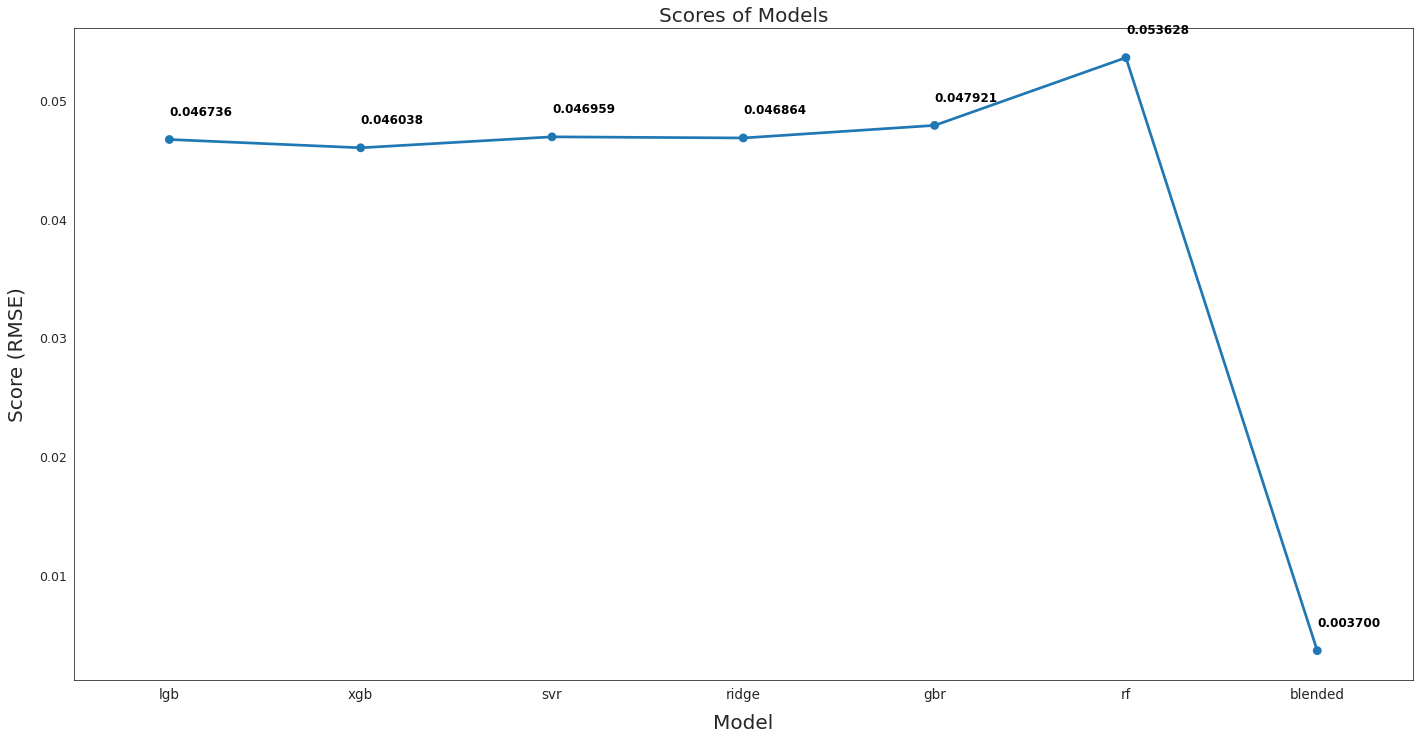

In [54]:
# set up figure
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

# plot points
ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

# edit graph
plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)
plt.title('Scores of Models', size=20)

plt.show()

# Submitting final predictions

In [55]:
# make predictions
raw_predictions = blend_models_predict(X_test)

# undo the boxcox transform
predictions = np.floor(inv_boxcox(raw_predictions, lamb))

# write data to file
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
output = pd.DataFrame({'Id': test["Id"], 'SalePrice': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [56]:
output.head()

,Id,SalePrice
0,1461,125745.0
1,1462,161542.0
2,1463,180734.0
3,1464,186383.0
4,1465,197385.0
